Dispositivo: cuda | Batch size: 32 | LR: 0.0001
Encontradas 86437 imagens
Metadados salvos em: oasis_dataset_metadata.parquet
Epoch 1/5
Train Loss: 1.2246 | Val Loss: 0.9274
Acc: 0.6263 | Prec: 0.3992 | Recall: 0.6251 | F1-macro: 0.4117
------------------------------------------------------------
Epoch 2/5
Train Loss: 0.6422 | Val Loss: 0.3191
Acc: 0.8693 | Prec: 0.7487 | Recall: 0.8969 | F1-macro: 0.8104
------------------------------------------------------------
Epoch 3/5
Train Loss: 0.2320 | Val Loss: 0.0953
Acc: 0.9274 | Prec: 0.8785 | Recall: 0.9729 | F1-macro: 0.9181
------------------------------------------------------------
Epoch 4/5
Train Loss: 0.1040 | Val Loss: 0.0867
Acc: 0.9414 | Prec: 0.8653 | Recall: 0.9758 | F1-macro: 0.9122
------------------------------------------------------------
Epoch 5/5
Train Loss: 0.0884 | Val Loss: 0.0568
Acc: 0.9796 | Prec: 0.9443 | Recall: 0.9833 | F1-macro: 0.9629
------------------------------------------------------------
Treinamento co

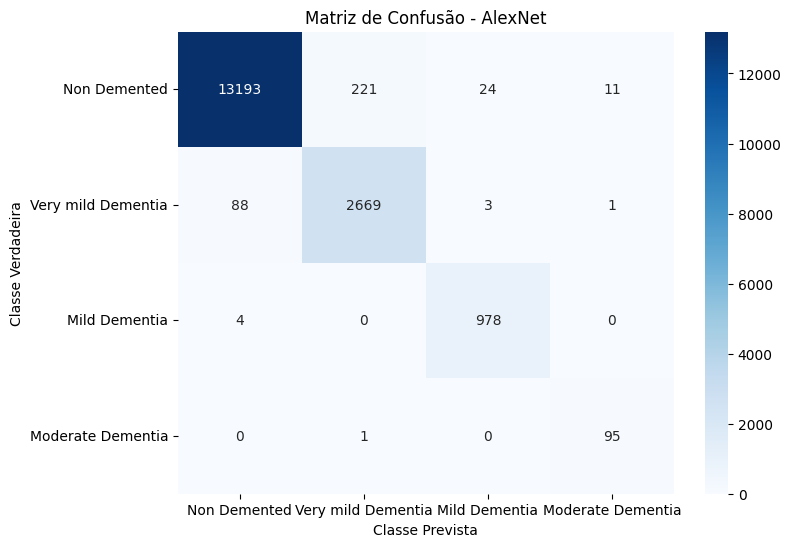

Preparando dados para análise SHAP...
Coletadas 64 imagens para análise SHAP
Calculando explicações SHAP...
SHAP values calculados com sucesso!
Número de classes (SHAP): 4
Forma do SHAP para a classe 0: (10, 3, 224, 224)


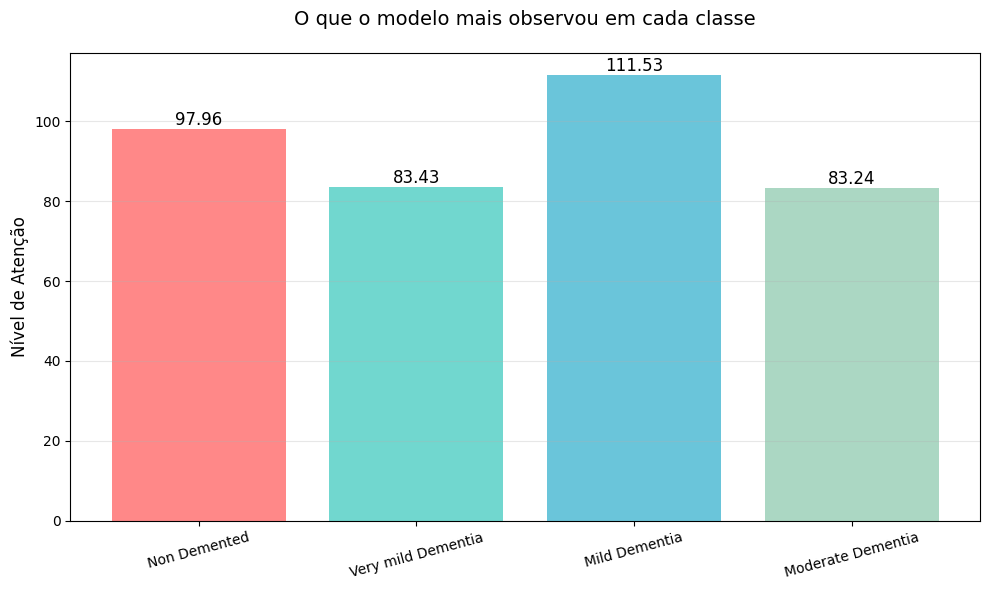

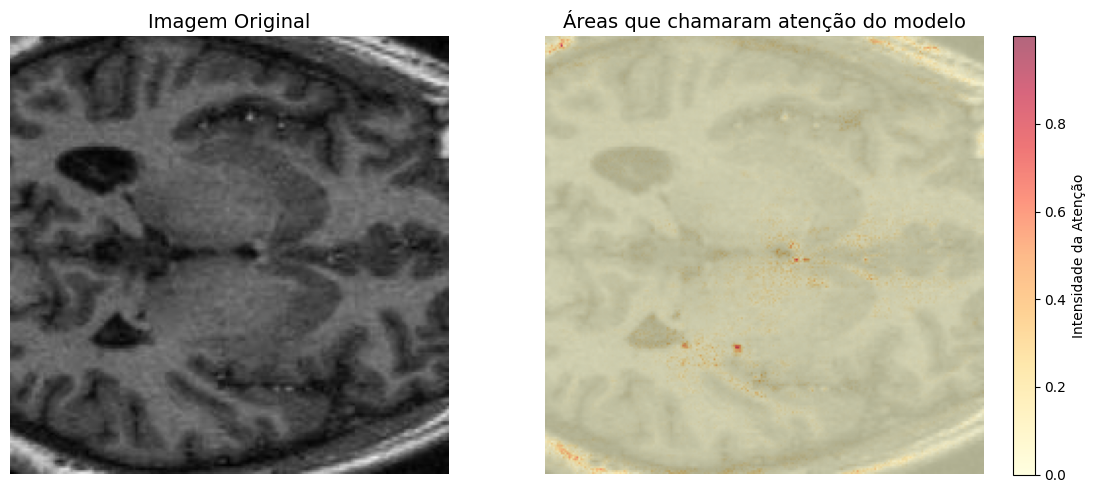

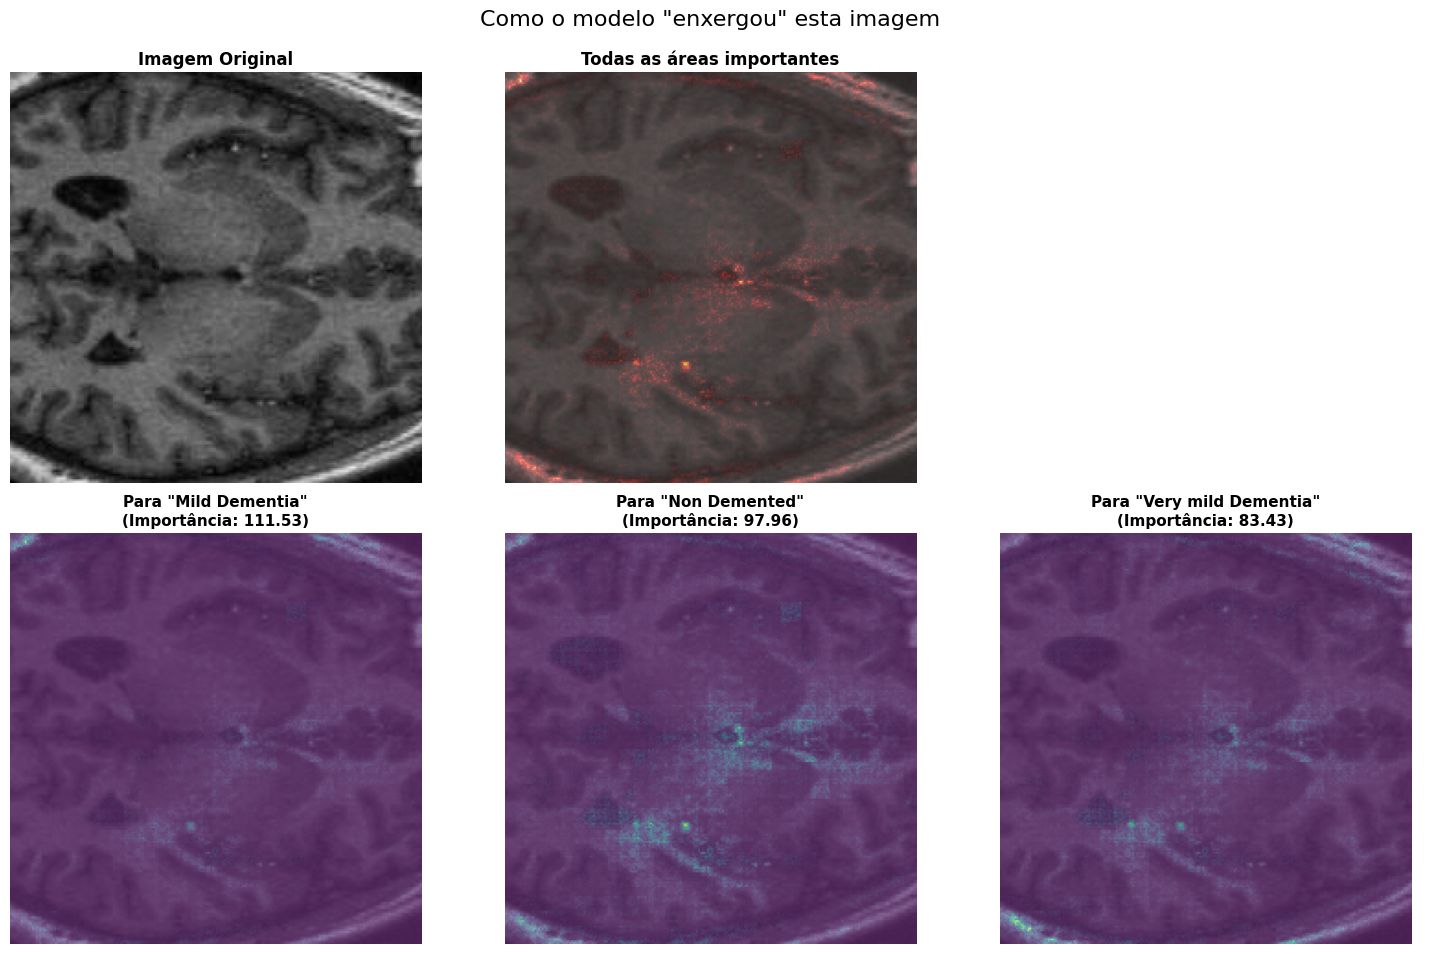

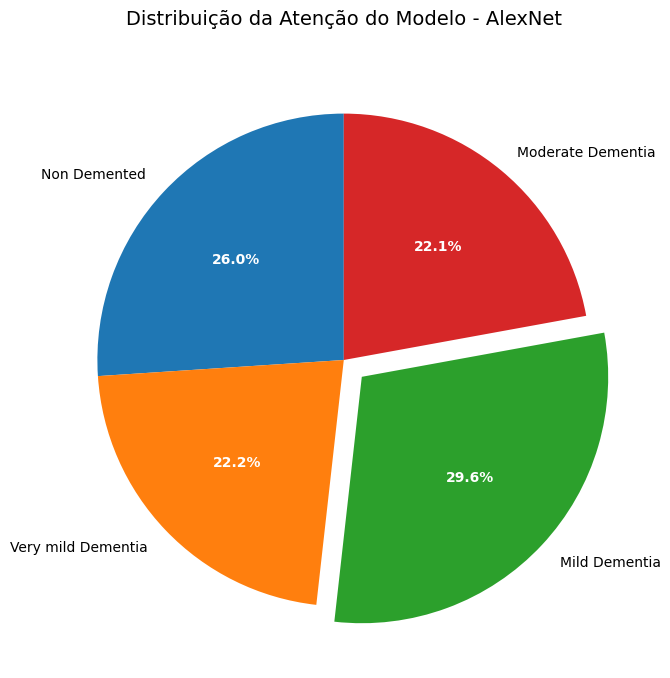


RELATÓRIO SIMPLES - ANÁLISE DA IMAGEM (AlexNet)

**Análise da Imagem:**
   • Classe mais provável: 'Mild Dementia'
   • Segunda opção: 'Non Demented'
   • Confiança na decisão: 29.6%

**Padrões identificados:**
   • O modelo considera múltiplas possibilidades

**Para leigos:**
   O algoritmo de IA analisou esta imagem e identificou padrões
   que se assemelham mais a 'Mild Dementia'.
   As áreas coloridas mostram onde o modelo 'prestou atenção'.

Visualizações explicativas criadas com sucesso!
Processo concluído! Artefatos salvos em: outputs_tcc


In [2]:
# Projeto de TCC - Engenharia de Software aplicado à Ciência de Dados
# Autor: Lucas José Pereira da Costa
# Descrição: Pipeline organizado para download, preparação, treinamento e interpretação
#            de um modelo CNN (AlexNet) no dataset OASIS. Estrutura pensada para
#            documentação acadêmica e reprodutibilidade experimental.
# ============================================================

import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import polars as pl
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap
import os
import json

# ============================================================
# HYPERPARÂMETROS E CONFIGURAÇÕES EXPERIMENTAIS
# (coloque aqui todos os hiperparâmetros para fácil documentação)
# ============================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5
STEP_SIZE = 5
GAMMA = 0.1
NUM_WORKERS = 2
PIN_MEMORY = True
RANDOM_SEED = 42

# Paths / nomes de arquivos
METADATA_PARQUET = "oasis_dataset_metadata.parquet"
METRICS_CSV = "alexnet_metrics.csv"
CONFUSION_NPY = "alexnet_confusion_matrix.npy"
OUTPUT_DIR = "outputs_tcc"

# Criar pasta de saída
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Registrar configurações (útil para reproducibilidade)
run_config = {
    "device": str(DEVICE),
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "num_epochs": NUM_EPOCHS,
    "step_size": STEP_SIZE,
    "gamma": GAMMA,
    "num_workers": NUM_WORKERS,
    "pin_memory": PIN_MEMORY,
    "random_seed": RANDOM_SEED
}
with open(os.path.join(OUTPUT_DIR, "run_config.json"), "w") as f:
    json.dump(run_config, f, indent=2)

print(f"Dispositivo: {DEVICE} | Batch size: {BATCH_SIZE} | LR: {LEARNING_RATE}")

# ============================================================
# DOWNLOAD E PRÉ-PROCESSAMENTO DO DATASET (METADADOS)
# ============================================================
path = kagglehub.dataset_download("ninadaithal/imagesoasis")

# Converter dataset de imagens em DataFrame Polars para EDA/meta
data_path = Path(path) / "Data"

image_paths = []
for p in data_path.rglob('*.*'):
    if p.is_file():
        parts = p.parts
        if len(parts) >= 2:
            class_name = parts[-2]  # pasta = classe
            file_name = parts[-1]   # nome do arquivo
            image_paths.append((class_name, file_name, str(p)))

print(f"Encontradas {len(image_paths)} imagens")

df = pl.DataFrame({
    'class': [x[0] for x in image_paths],
    'image': [x[1] for x in image_paths],
    'path': [x[2] for x in image_paths]
})

df.write_parquet(METADATA_PARQUET)
print(f"Metadados salvos em: {METADATA_PARQUET}")

# ============================================================
# TRANSFORMS E DEFINIÇÃO DO DATASET TORCH
# ============================================================
transform = transforms.Compose([
    transforms.Resize((248, 496)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class OASISDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.class_to_idx = {
            'Non Demented': 0,
            'Very mild Dementia': 1,
            'Mild Dementia': 2,
            'Moderate Dementia': 3
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.row(idx)
        img_path = row[2]
        class_name = row[0]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[class_name]
        return image, label

# Carregar metadados e dataset
df = pl.read_parquet(METADATA_PARQUET)
dataset = OASISDataset(df, transform=transform)

# ============================================================
# SPLIT TREINO / VALIDAÇÃO e DATALOADERS
# ============================================================
torch.manual_seed(RANDOM_SEED)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# ============================================================
# MODELO: SafeAlexNet (ajustes para compatibilidade com SHAP)
# ============================================================
class SafeAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SafeAlexNet, self).__init__()
        self.alexnet = models.alexnet(weights=None)
        # Desativar operações inplace em todas as ReLU
        for m in self.alexnet.modules():
            if isinstance(m, nn.ReLU):
                m.inplace = False
        num_ftrs = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.alexnet(x)

model = SafeAlexNet(num_classes=4).to(DEVICE)

# ============================================================
# LOSS, OTIMIZADOR E SCHEDULER
# ============================================================
class_weights = torch.tensor([0.3215, 1.5744, 4.3201, 44.2812], dtype=torch.float32).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# ============================================================
# TREINAMENTO (loop principal)
# ============================================================
metrics_history = []
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # --- Training ---
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Estatísticas por epoch
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    epoch_time = time.time() - epoch_start

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1-macro: {f1:.4f}')
    print('-' * 60)

    # Guardar métricas
    metrics_history.append({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "epoch_time_sec": epoch_time
    })

    scheduler.step()

total_time = time.time() - start_time
print(f"Treinamento concluído em {total_time:.1f} segundos")

# ============================================================
# SALVAR MÉTRICAS E MATRIZ DE CONFUSÃO
# ============================================================
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv(os.path.join(OUTPUT_DIR, METRICS_CSV), index=False)
print(f"Métricas salvas em: {os.path.join(OUTPUT_DIR, METRICS_CSV)}")

cm = confusion_matrix(all_labels, all_preds)
print("Matriz de Confusão:\n", cm)
np.save(os.path.join(OUTPUT_DIR, CONFUSION_NPY), cm)

# Plot da matriz de confusão
class_names = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão - AlexNet')
plt.savefig(os.path.join(OUTPUT_DIR, 'alexnet_confusion_matrix.png'))
plt.show()

# ============================================================
# PREPARAÇÃO PARA SHAP - Coletar dados de validação (subconjunto)
# ============================================================
print("Preparando dados para análise SHAP...")

test_images = []
test_labels = []
model.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        if i >= 2:  # pegar apenas 2 batches (controlar carga)
            break
        test_images.append(images)
        test_labels.append(labels)

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)

print(f"Coletadas {len(test_images)} imagens para análise SHAP")

# Converter algumas imagens para numpy para visualização
test_images_np = []
for i in range(min(10, len(test_images))):
    img = test_images[i].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # desnormalizar
    img = np.clip(img, 0, 1)
    test_images_np.append(img)

test_labels = test_labels.cpu().numpy()

# ============================================================
# CÁLCULO DAS EXPLICAÇÕES SHAP
# ============================================================
print("Calculando explicações SHAP...")

# GradientExplainer espera um modelo e um tensor de referência (background)
# Usamos um pequeno background retirado do conjunto de validação
background = test_images[:min(10, len(test_images))].to(DEVICE)

# Criar explainer (pode variar dependendo da versão do shap)
explainer = shap.GradientExplainer(model, background)

# Calcular valores SHAP para um subconjunto (atenção ao custo computacional)
shap_values = explainer.shap_values(test_images[:min(10, len(test_images))].to(DEVICE))

print("SHAP values calculados com sucesso!")
if isinstance(shap_values, list) and len(shap_values) > 0:
    print(f"Número de classes (SHAP): {len(shap_values)}")
    print(f"Forma do SHAP para a classe 0: {shap_values[0].shape}")

# ============================================================
# ANÁLISE EXPLICATIVA (VISUALIZAÇÕES SIMPLES)
# ============================================================
def gerar_visualizacoes_explicativas(shap_values, test_images_np, test_labels, class_names, output_dir):
    """
    Cria visualizações simples e intuitivas para apresentação.
    Salva figuras em output_dir.
    """
    # 1. GRÁFICO DE BARRAS - IMPORTÂNCIA DAS CLASSES
    importancias = []
    for i in range(len(class_names)):
        importancia_total = np.sum(np.abs(shap_values[i][0]))
        importancias.append(importancia_total)

    plt.figure(figsize=(10, 6))
    cores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(class_names)]
    barras = plt.bar(class_names, importancias, color=cores, alpha=0.8)
    for barra, valor in zip(barras, importancias):
        plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
                 f'{valor:.2f}', ha='center', va='bottom', fontsize=12)
    plt.title('O que o modelo mais observou em cada classe', fontsize=14, pad=20)
    plt.ylabel('Nível de Atenção', fontsize=12)
    plt.xticks(rotation=15)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'alexnet_importancia_classes.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 2. MAPA DE CALOR SIMPLIFICADO - "MAPAS DE ATENÇÃO"
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(test_images_np[0])
    axes[0].set_title('Imagem Original', fontsize=14)
    axes[0].axis('off')

    mapa_atencao = np.zeros_like(shap_values[0][0][0])
    for i in range(len(class_names)):
        mapa_atencao += np.abs(np.mean(shap_values[i][0], axis=0))

    mapa_atencao = (mapa_atencao - mapa_atencao.min()) / (mapa_atencao.max() - mapa_atencao.min() + 1e-8)

    axes[1].imshow(test_images_np[0], alpha=0.8)
    im = axes[1].imshow(mapa_atencao, cmap='YlOrRd', alpha=0.6)
    axes[1].set_title('Áreas que chamaram atenção do modelo', fontsize=14)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], label='Intensidade da Atenção')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'alexnet_mapa_atencao.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 3. COMPARAÇÃO LADO A LADO - TOP 3 CLASSES
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Como o modelo "enxergou" esta imagem\n', fontsize=16, y=0.95)

    axes[0,0].imshow(test_images_np[0])
    axes[0,0].set_title('Imagem Original', fontweight='bold')
    axes[0,0].axis('off')

    axes[0,1].imshow(test_images_np[0], alpha=0.7)
    axes[0,1].imshow(mapa_atencao, cmap='hot', alpha=0.5)
    axes[0,1].set_title('\nTodas as áreas importantes', fontweight='bold')
    axes[0,1].axis('off')

    axes[0,2].axis('off')

    class_ranking = []
    for i in range(len(class_names)):
        importancia = np.sum(np.abs(shap_values[i][0]))
        class_ranking.append((class_names[i], importancia, i))

    class_ranking.sort(key=lambda x: x[1], reverse=True)

    for idx, (class_name, importancia, class_idx) in enumerate(class_ranking[:3]):
        mapa_classe = np.mean(np.abs(shap_values[class_idx][0]), axis=0)
        mapa_classe = (mapa_classe - mapa_classe.min()) / (mapa_classe.max() - mapa_classe.min() + 1e-8)
        axes[1,idx].imshow(test_images_np[0], alpha=0.7)
        axes[1,idx].imshow(mapa_classe, cmap='viridis', alpha=0.6)
        axes[1,idx].set_title(f'Para \"{class_name}\"\n(Importância: {importancia:.2f})', fontweight='bold', fontsize=11)
        axes[1,idx].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'alexnet_analise_completa.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 4. GRÁFICO DE PIZZA - DISTRIBUIÇÃO DA ATENÇÃO
    plt.figure(figsize=(8, 8))
    total_importancia = sum(importancias)
    porcentagens = [imp/total_importancia * 100 for imp in importancias]
    explode = [0.1 if i == np.argmax(importancias) else 0 for i in range(len(class_names))]
    wedges, texts, autotexts = plt.pie(porcentagens, labels=class_names, autopct='%1.1f%%',
                                      explode=explode, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    plt.title('Distribuição da Atenção do Modelo - AlexNet', fontsize=14, pad=20)
    plt.savefig(os.path.join(output_dir, 'alexnet_distribuicao_atencao.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 5. EXPLICAÇÃO TEXTUAL SIMPLES (console)
    print("\n" + "="*60)
    print("RELATÓRIO SIMPLES - ANÁLISE DA IMAGEM (AlexNet)")
    print("="*60)
    classe_principal = class_ranking[0][0]
    segunda_classe = class_ranking[1][0]
    print(f"\n**Análise da Imagem:**")
    print(f"   • Classe mais provável: '{classe_principal}'")
    print(f"   • Segunda opção: '{segunda_classe}'")
    print(f"   • Confiança na decisão: {class_ranking[0][1]/total_importancia*100:.1f}%")
    print(f"\n**Padrões identificados:**")
    if class_ranking[0][1] > total_importancia * 0.4:
        print(f"   • O modelo está bastante confiante na classe '{classe_principal}'")
    else:
        print(f"   • O modelo considera múltiplas possibilidades")
    print(f"\n**Para leigos:**")
    print(f"   O algoritmo de IA analisou esta imagem e identificou padrões")
    print(f"   que se assemelham mais a '{classe_principal}'.")
    print(f"   As áreas coloridas mostram onde o modelo 'prestou atenção'.")

# Executar visualizações explicativas (se shap_values válidos)
try:
    if 'shap_values' in locals() and isinstance(shap_values, list):
        gerar_visualizacoes_explicativas(shap_values, test_images_np, test_labels, class_names, OUTPUT_DIR)
        print("\nVisualizações explicativas criadas com sucesso!")
    else:
        print("SHAP values não foram calculados corretamente ou formato inesperado.")
except Exception as e:
    print(f"Erro ao criar visualizações explicativas: {e}")
    import traceback
    traceback.print_exc()

print("Processo concluído! Artefatos salvos em:", OUTPUT_DIR)

Gerando explicações com LIME...
Formato da imagem original para LIME: (224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

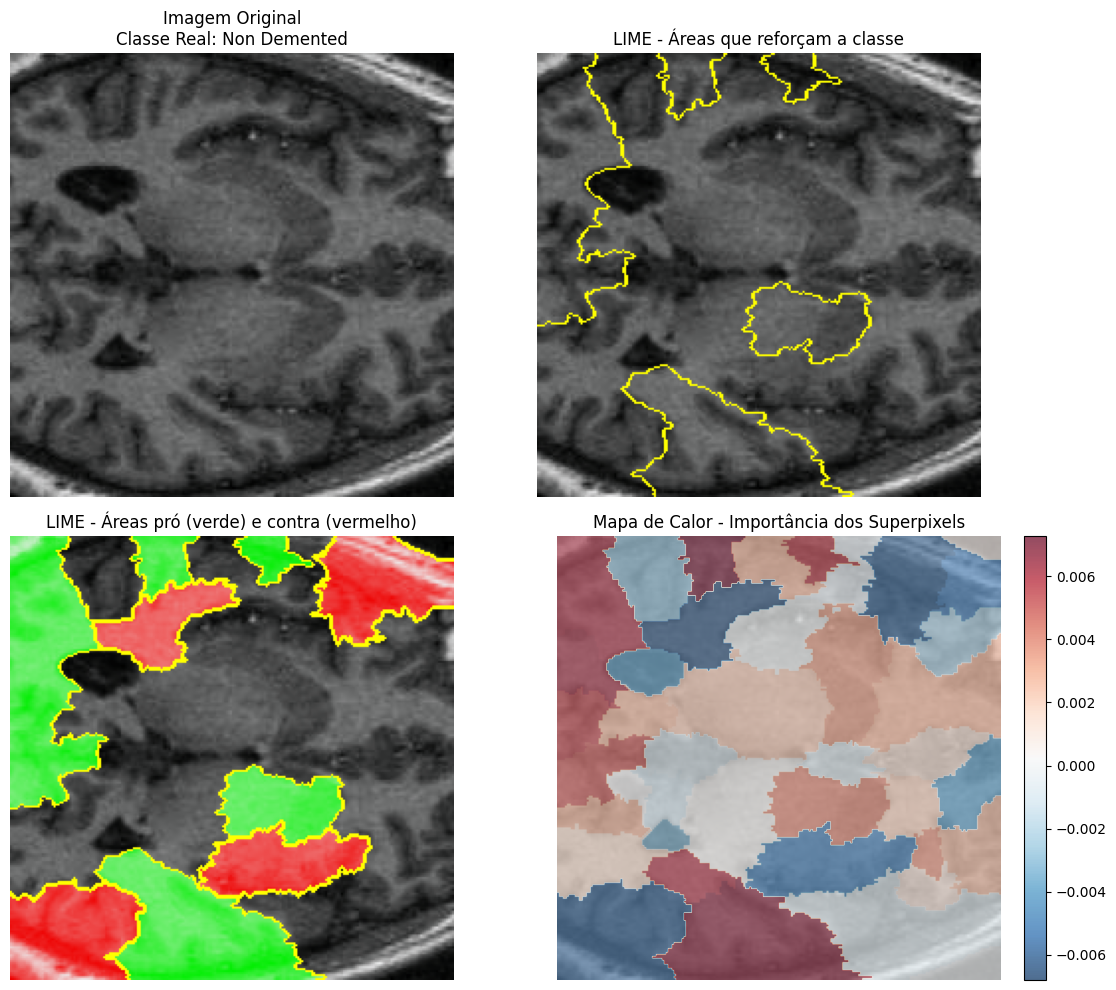


✅ Análise LIME gerada e salva em: outputs_tcc/alexnet_lime_analysis.png

RELATÓRIO LIME - ANÁLISE DA IMAGEM
🔹 Classe prevista pelo modelo: Non Demented
🔹 Probabilidade associada: 1.000

🔸 Superpixels com maior contribuição POSITIVA:
   • Superpixel 1: +0.007
   • Superpixel 39: +0.007
   • Superpixel 12: +0.006
   • Superpixel 8: +0.006
   • Superpixel 36: +0.006

🔸 Superpixels com maior contribuição NEGATIVA:
   • Superpixel 9: -0.007
   • Superpixel 5: -0.006
   • Superpixel 40: -0.006
   • Superpixel 7: -0.005
   • Superpixel 33: -0.005


In [7]:
# ============================================================
# LIME - Interpretação do modelo (AlexNet - OASIS)
# ============================================================
print("Gerando explicações com LIME...")

try:
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
    import matplotlib.patches as patches

    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images_numpy):
        """Wrapper para previsão no formato esperado pelo LIME"""
        model.eval()
        images_tensor = torch.tensor(images_numpy).permute(0, 3, 1, 2).float().to(DEVICE)

        # 🔹 Aplicar normalização igual ao transform utilizado no treinamento
        normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
        for i in range(images_tensor.shape[0]):
            images_tensor[i] = normalize(images_tensor[i])

        with torch.no_grad():
            outputs = model(images_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
        return probs

    # Escolher uma imagem de teste
    i = 0  # pode alterar para outras imagens
    test_image = (test_images_np[i] * 255).astype(np.uint8)

    print(f"Formato da imagem original para LIME: {test_image.shape}")

    explanation = explainer.explain_instance(
        test_image,
        predict_fn,
        top_labels=3,
        hide_color=None,        # 🔹 Mantém o fundo original em vez de preto
        num_samples=1000        # 🔹 Suficiente para boa explicação sem pesar muito
    )

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Imagem Original
    axes[0, 0].imshow(test_image)
    axes[0, 0].set_title(f'Imagem Original\nClasse Real: {class_names[test_labels[i]]}')
    axes[0, 0].axis('off')

    # 2. LIME - Áreas Positivas
    temp_pos, mask_pos = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    axes[0, 1].imshow(mark_boundaries(temp_pos / 255.0, mask_pos))
    axes[0, 1].set_title('LIME - Áreas que reforçam a classe')
    axes[0, 1].axis('off')

    # 3. LIME - Áreas Positivas e Negativas
    temp_both, mask_both = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=15,
        hide_rest=False
    )
    axes[1, 0].imshow(mark_boundaries(temp_both / 255.0, mask_both))
    axes[1, 0].set_title('LIME - Áreas pró (verde) e contra (vermelho)')
    axes[1, 0].axis('off')

    # 4. Heatmap de importância
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    im = axes[1, 1].imshow(heatmap, cmap='RdBu_r', alpha=0.7)
    axes[1, 1].imshow(test_image, alpha=0.3)
    axes[1, 1].set_title('Mapa de Calor - Importância dos Superpixels')
    axes[1, 1].axis('off')
    plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    lime_output_path = os.path.join(OUTPUT_DIR, 'alexnet_lime_analysis.png')
    plt.savefig(lime_output_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Análise LIME gerada e salva em: {lime_output_path}")

    # ANÁLISE TEXTUAL LIME
    print("\n" + "="*60)
    print("RELATÓRIO LIME - ANÁLISE DA IMAGEM")
    print("="*60)

    top_label = explanation.top_labels[0]
    predicted_probs = predict_fn(np.array([test_image]))[0]
    print(f"🔹 Classe prevista pelo modelo: {class_names[top_label]}")
    print(f"🔹 Probabilidade associada: {predicted_probs[top_label]:.3f}")

    print("\n🔸 Superpixels com maior contribuição POSITIVA:")
    for feature, weight in [(f, w) for f, w in explanation.local_exp[top_label] if w > 0][:5]:
        print(f"   • Superpixel {feature}: +{weight:.3f}")

    print("\n🔸 Superpixels com maior contribuição NEGATIVA:")
    for feature, weight in [(f, w) for f, w in explanation.local_exp[top_label] if w < 0][:5]:
        print(f"   • Superpixel {feature}: {weight:.3f}")

except Exception as e:
    print(f"⚠️ LIME não pôde ser executado: {e}")
    import traceback
    traceback.print_exc()
    print("Pulando etapa de LIME...")